In [153]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer

### APPLICATIONS TABLE

In [154]:
app_train = pd.read_csv("../../Project/Home_credits_loan/all/application_train.csv")

#Values "XNA" (not availables) will be replaced by NaN values
app_train.replace("XNA", np.nan, inplace=True)

In [155]:
#See if there are any duplicated rows
duplicate_rows = app_train[app_train.duplicated()]
len(duplicate_rows)

0

#### Dividing the variables by type to facilitate the EDA and Data Cleaning

In [156]:
variables_type = pd.DataFrame(app_train.dtypes)

cat_variables = list(variables_type[variables_type[0] == "object"].index)

int_variables = list(variables_type[variables_type[0] == "int64"].index)

float_variables = list(variables_type[variables_type[0] == "float64"].index)

cat_binary_variables = []
for i in app_train:
    if ((list(app_train[i].unique()) == [0,1]) or (list(app_train[i].unique()) == [1,0])) and (i != "TARGET"):
        cat_binary_variables.append(i)

int_with_no_binary = [j for j in int_variables if j not in cat_binary_variables and j not in ["SK_ID_CURR", "TARGET"]]

num_variables = int_with_no_binary + float_variables

print("Categorical variables (non-binary coded):", cat_variables)
print("Categorical variables (binary):", cat_binary_variables)
print("Numerical variables:", num_variables)

Categorical variables (non-binary coded): ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Categorical variables (binary): ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUM

#### Analyzing missing values

Building a model on variables that have higher than 50% missing values may lead to misleading results since we either have to decrease our sample greatly or substitute the missing values by the median

In [157]:
#List the variables with missing values higher or equal to 50% to exclude these variables later on
#List the variables with missing values higher than 0% and lower than 50% to preprocess them later on
miss_lower50 = []
miss_higher50 = []

for i in app_train:
    pct_missing = (app_train[i].isna().sum()/len(app_train[i]))*100
    if pct_missing > 0 and pct_missing < 50:
        miss_lower50.append(i)
    if pct_missing >= 50:
        miss_higher50.append(i)

In [158]:
#Exclude the variables with missing values higher or equal to 50%
cat_variables = [i for i in cat_variables if i not in miss_higher50]
cat_binary_variables = [i for i in cat_binary_variables if i not in miss_higher50]
num_variables = [i for i in num_variables if i not in miss_higher50]

#### Cleaning all remaining variables

##### Categorical variables

In [159]:
#Print the unique values of the categorical variables to see if they are correctly categorized
for i in cat_variables:
    print(i, app_train[i].unique())

NAME_CONTRACT_TYPE ['Cash loans' 'Revolving loans']
CODE_GENDER ['M' 'F' nan]
FLAG_OWN_CAR ['N' 'Y']
FLAG_OWN_REALTY ['Y' 'N']
NAME_TYPE_SUITE ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 

Findings:
- FLAG_OWN_CAR, FLAG_OWN_REALTY AND EMERGENCYSTATE_MODE are already binary variables codified in a different way (Yes/No)

In [160]:
#Change binary variables from Yes/No to 1/0
app_train["FLAG_OWN_CAR"] = app_train["FLAG_OWN_CAR"].apply(lambda x: 0 if x == 'N' else 1)
app_train["FLAG_OWN_REALTY"] = app_train["FLAG_OWN_REALTY"].apply(lambda x: 0 if x == 'N' else 1)
app_train["EMERGENCYSTATE_MODE"] = app_train["EMERGENCYSTATE_MODE"].apply(lambda x: 0 if x == 'No' else (1 if x == 'Yes' else x))

#Exclude them from cat_variables and include them in cat_binary_variables (useful for the final pipeline)
cat_variables = [i for i in cat_variables if i not in ["FLAG_OWN_CAR","FLAG_OWN_REALTY","EMERGENCYSTATE_MODE"]]
cat_binary_variables.extend(["FLAG_OWN_CAR","FLAG_OWN_REALTY","EMERGENCYSTATE_MODE"])

##### Numerical variables

In [161]:
#Using describe method for numerical variables to get summary statistics and explore the data
app_train[num_variables].describe()

,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.417052,-16036.995067,63815.045904,-2994.202373,2.052463,2.031521,12.063419,1.687979e+05,5.990260e+05,27108.573909,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.722121,4363.988632,141275.766519,1509.450419,0.509034,0.502737,3.265832,2.371231e+05,4.024908e+05,14493.737315,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,-25229.000000,-17912.000000,-7197.000000,1.000000,1.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-19682.000000,-2760.000000,-4299.000000,2.000000,2.000000,10.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-15750.000000,-1213.000000,-3254.000000,2.000000,2.000000,12.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,-12413.000000,-289.000000,-1720.000000,2.000000,2.000000,14.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,-7489.000000,365243.000000,0.000000,3.000000,3.000000,23.000000,1.170000e+08,4.050000e+06,258025.500000,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Findings:
- "DAYS(...)" variables are counter-intuitively negative
- "REGION_RATING_CLIENT(...)" variables should be consider categorical since they only have values 1, 2 and 3
- DAYS_EMPLOYED mean is 63815 (equivalent to around 174.8 years of experience), so there should be outliers (wrongly inserted values) we need to look deeper at

In [162]:
#Exclude them "REGION_RATING_CLIENT(...)" variables from num_variables and include them in cat_variables (useful for the final pipeline)
num_variables = [i for i in num_variables if i not in ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']]
cat_variables.extend(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'])

<AxesSubplot:>

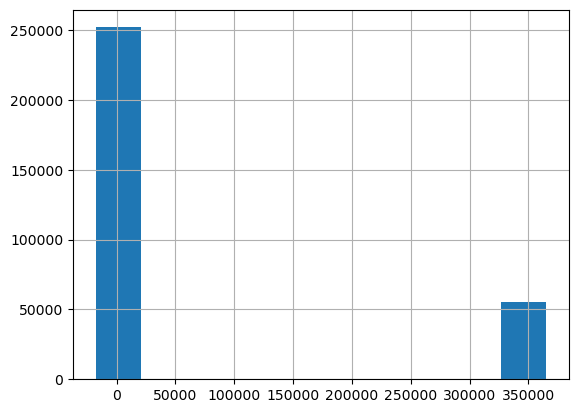

In [163]:
#Plot the DAYS_EMPLOYED variable to see why mean is equivalent to 174.8 years of experience (outliers that don't make sense)
app_train["DAYS_EMPLOYED"].hist()

In [164]:
#See how many wrongly inserted values there is and if there is a specific value that is causing it
print(app_train[app_train["DAYS_EMPLOYED"] > 325000][["DAYS_EMPLOYED"]].value_counts())

#After finding that there is 55374 with valu 365243 days employed, we set them to NaN (to be cleaned in the preprocessing pipeline)
app_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

DAYS_EMPLOYED
365243           55374
dtype: int64


In [165]:
#Put day variables in a list to be transformed together in the preprocessing pipeline, and exclude them from num_variables 
day_variables = [col for col in app_train.columns if 'DAYS' in col]
num_variables = [i for i in num_variables if i not in day_variables]

#### Transformation Pipeline

In [166]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, app_train, y=None):
        return self
    def transform(self, app_train):
        return app_train[self.attribute_names].values
    def get_feature_names(self):
        return self.attribute_names

In [167]:
class NegativeToPositive(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, app_train, y=None):
        return self
    def transform(self, app_train):
        app_train[self.attribute_names] = abs(app_train[self.attribute_names])
        return app_train[self.attribute_names]

In [168]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])
day_col_pipeline = Pipeline([
        ('neg_to_pos', NegativeToPositive(day_variables)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
        ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder())
        ])
cat_binary_pipeline = Pipeline ([
        ('selector', DataFrameSelector(cat_binary_variables)),
        ('imputer', SimpleImputer(strategy="most_frequent"))
        ])

In [169]:
preprocess_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_variables),
        ("days_pipeline", day_col_pipeline, day_variables),
        ("cat_pipeline", cat_pipeline, cat_variables),
        ("cat_binary_pipeline", cat_binary_pipeline, cat_binary_variables)
])

In [170]:
preprocess_pipeline.fit(app_train)

preprocessed_app_train = preprocess_pipeline.transform(app_train)

c:\Users\HP\anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [171]:
cat_feature_names = list(preprocess_pipeline.named_transformers_['cat_pipeline'].named_steps['cat_encoder'].get_feature_names(cat_variables))
feature_names = num_variables + day_variables + cat_feature_names + cat_binary_variables

c:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [172]:
transformed_app_train_df = pd.DataFrame(preprocessed_app_train, columns=feature_names)
transformed_app_train_df = pd.concat([app_train[["SK_ID_CURR", "TARGET"]],transformed_app_train_df], axis=1)
transformed_app_train_df

,SK_ID_CURR,TARGET,CNT_CHILDREN,HOUR_APPR_PROCESS_START,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,CNT_FAM_MEMBERS,...,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,100002,1,-0.577538,-0.631821,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100003,0,-0.577538,-0.325620,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.167638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,-0.577538,-0.938022,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,100006,0,-0.577538,1.511587,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.167638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,100007,0,-0.577538,-0.325620,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,-0.577538,0.899185,-0.047646,-0.855489,0.031015,-0.848433,0.845396,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307507,456252,0,-0.577538,-1.244224,-0.408219,-0.818594,-1.042333,-0.848433,0.310593,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
307508,456253,0,-0.577538,-0.938022,-0.066623,0.195379,0.198056,0.126415,-1.147120,-1.265722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
307509,456254,1,-0.577538,-0.938022,0.009287,-0.568757,-0.476318,-0.592535,-1.124635,-0.167638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [173]:
transformed_app_train_df[day_variables]

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
0,-1.506880,-0.755835,-0.379837,-0.579154,0.206992
1,0.166821,-0.497899,-1.078697,-1.790855,-0.163107
2,0.689509,-0.948701,-0.206116,-0.306869,-0.178831
3,0.680114,0.368597,1.375829,-0.369143,-0.418306
4,0.892535,0.368129,-0.191639,0.307263,0.173126
...,...,...,...,...,...
307506,-1.537586,-0.943552,0.984955,-0.670578,-0.834365
307507,1.085707,-0.282562,-0.169782,0.725959,-1.164552
307508,-0.245417,2.653975,0.497002,1.428203,1.144334
307509,-0.934008,1.186408,-0.688107,-1.366859,-0.775101
